In [36]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import dates
%matplotlib inline
plt.rcParams["figure.figsize"] = [30, 4]
import seaborn as sns

from scipy.optimize import minimize

from datetime import datetime
from datetime import timedelta

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, \
    median_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error
    
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARMA, ARIMA
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [37]:
raw_data = pd.read_csv("Metro_Interstate_Traffic_Volume.csv", usecols=["holiday", "temp", "date_time", "traffic_volume"], parse_dates=["date_time"])

raw_data.head()

,holiday,temp,date_time,traffic_volume
0,None,288.28,2012-10-02 09:00:00,5545
1,None,289.36,2012-10-02 10:00:00,4516
2,None,289.58,2012-10-02 11:00:00,4767
3,None,290.13,2012-10-02 12:00:00,5026
4,None,291.14,2012-10-02 13:00:00,4918


In [38]:
raw_data["holiday"].unique()

array(['None', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [39]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   holiday         48204 non-null  object        
 1   temp            48204 non-null  float64       
 2   date_time       48204 non-null  datetime64[ns]
 3   traffic_volume  48204 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.5+ MB


In [40]:
raw_data.shape[0]

48204

In [41]:
raw_data["date_time"].unique().shape[0]

40575

In [42]:
raw_data.drop_duplicates(subset=["date_time"], inplace=True)

In [43]:
raw_data.shape[0]

40575

In [44]:
raw_data.set_index("date_time", inplace=True)

In [45]:
raw_data.head()

,holiday,temp,traffic_volume
date_time,,,
2012-10-02 09:00:00,None,288.28,5545
2012-10-02 10:00:00,None,289.36,4516
2012-10-02 11:00:00,None,289.58,4767
2012-10-02 12:00:00,None,290.13,5026
2012-10-02 13:00:00,None,291.14,4918


In [46]:
def plot_data(df):
    df.plot(figsize=(30,4))
    plt.xticks(rotation=45)
    plt.show()

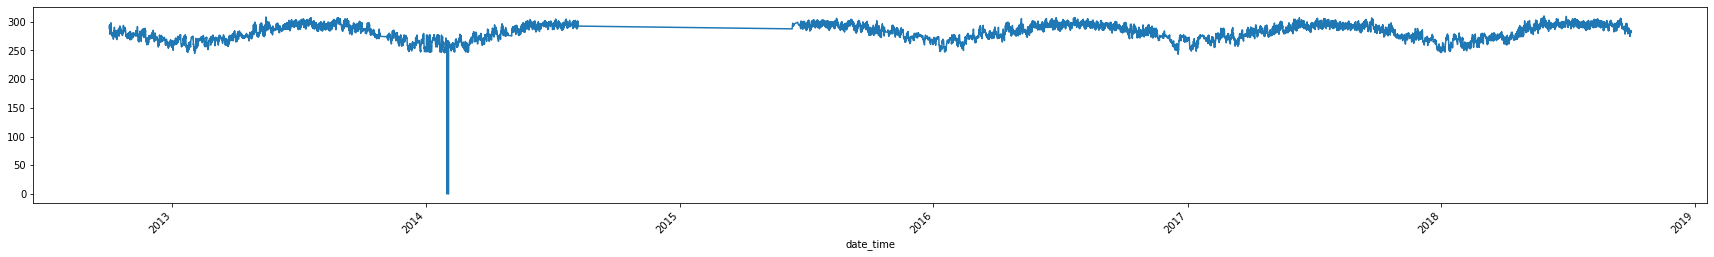

In [47]:
plot_data(raw_data["temp"])

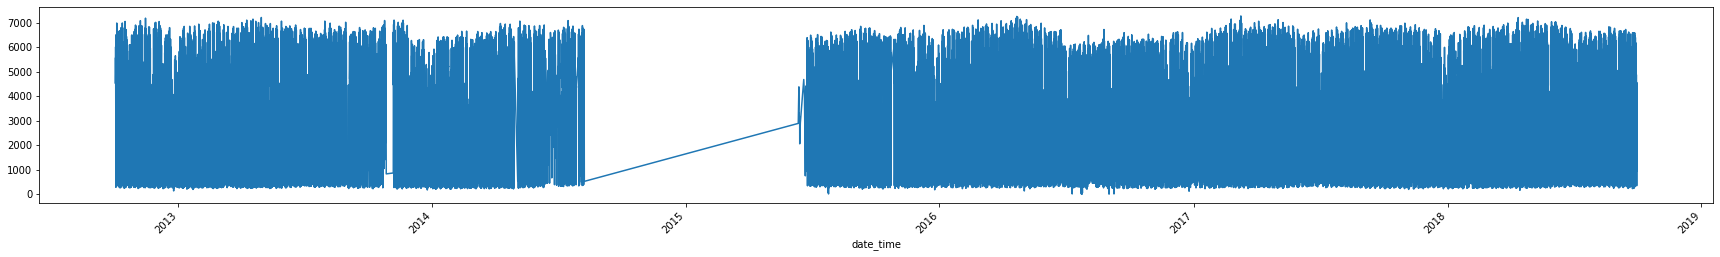

In [48]:
plot_data(raw_data["traffic_volume"])

In [49]:
raw_data.loc["2014-08-08" : "2015-06-23"]

,holiday,temp,traffic_volume
date_time,,,
2014-08-08 00:00:00,None,293.450,848
2014-08-08 01:00:00,None,292.380,516
2015-06-11 20:00:00,None,287.586,2886
2015-06-12 18:00:00,None,297.543,4380
2015-06-12 20:00:00,None,292.061,3095
2015-06-12 21:00:00,None,292.061,3299
2015-06-13 21:00:00,None,294.840,3040
2015-06-13 23:00:00,None,293.137,2051
2015-06-14 20:00:00,None,296.064,2909


На графике и в таблице видно, что в период с 2014-08-08 01:00:00 по 2015-06-11 20:00:00 даных нет.
Отбросим данные до 2015-06-22 18:00:00, т.к. в последующих данных есть повторяемость отбрасываемых, т.е. мы не отбрасываем уникальные данные, а также мы не делаем долгосрочных прогнозов.


In [50]:
data = raw_data.loc["2015-06-22 18:00:00" :].copy()
data_ = data.copy()

Закодируем текстовые значения.

In [51]:
le = LabelEncoder()
le.fit(data["holiday"].values)
data["holiday"] = le.transform(data["holiday"].values)

In [52]:
data.head()

,holiday,temp,traffic_volume
date_time,,,
2015-06-22 18:00:00,7,295.744,4415
2015-06-24 04:00:00,7,287.741,923
2015-06-24 06:00:00,7,290.225,5834
2015-06-24 07:00:00,7,290.225,5401
2015-06-24 08:00:00,7,290.225,5097


In [53]:
data.tail(2)

,holiday,temp,traffic_volume
date_time,,,
2018-09-30 22:00:00,7,282.09,1450
2018-09-30 23:00:00,7,282.12,954


Создаем равномерный временной ряд с имеющейся начальной и конечной датой с такой же частотой как и у загруженных данных.

In [54]:
df = pd.DataFrame({"holiday": 0, "temp": 0., "traffic_volume": 0}, index=pd.date_range(data.index[0], data.index[-1], freq="H"))

In [55]:
df.head()

,holiday,temp,traffic_volume
2015-06-22 18:00:00,0,0.0,0
2015-06-22 19:00:00,0,0.0,0
2015-06-22 20:00:00,0,0.0,0
2015-06-22 21:00:00,0,0.0,0
2015-06-22 22:00:00,0,0.0,0


Суммируем датафреймы, пропущенным значениям будет присвоено NaN.

In [56]:
data = data + df

In [57]:
data.head()

,holiday,temp,traffic_volume
2015-06-22 18:00:00,7.0,295.744,4415.0
2015-06-22 19:00:00,NaN,NaN,NaN
2015-06-22 20:00:00,NaN,NaN,NaN
2015-06-22 21:00:00,NaN,NaN,NaN
2015-06-22 22:00:00,NaN,NaN,NaN


In [58]:
data.isnull().sum()

holiday           2043
temp              2043
traffic_volume    2043
dtype: int64

Видим, что имеется большое кол-во отстутcтвующих значений.

Найдем индексы отстутствующих значений.

In [59]:
values = data.isnull().values[:, 0]
idxs_nan = np.where(values == True)[0]

Посмотрим на временные метки отстутствующих значений.

In [60]:
data.loc[data.index[idxs_nan]]

,holiday,temp,traffic_volume
2015-06-22 19:00:00,NaN,NaN,NaN
2015-06-22 20:00:00,NaN,NaN,NaN
2015-06-22 21:00:00,NaN,NaN,NaN
2015-06-22 22:00:00,NaN,NaN,NaN
2015-06-22 23:00:00,NaN,NaN,NaN
...,...,...,...
2018-06-02 02:00:00,NaN,NaN,NaN
2018-08-07 07:00:00,NaN,NaN,NaN
2018-08-07 08:00:00,NaN,NaN,NaN
2018-08-07 09:00:00,NaN,NaN,NaN


In [61]:
data.interpolate(method='time', axis=0, inplace=True)

In [62]:
data["holiday"] = data["holiday"].astype(np.int64)

In [63]:
data.loc[data.index[idxs_nan]]

,holiday,temp,traffic_volume
2015-06-22 19:00:00,7,295.508618,4312.294118
2015-06-22 20:00:00,7,295.273235,4209.588235
2015-06-22 21:00:00,7,295.037853,4106.882353
2015-06-22 22:00:00,7,294.802471,4004.176471
2015-06-22 23:00:00,7,294.567088,3901.470588
...,...,...,...
2018-06-02 02:00:00,7,289.655000,638.000000
2018-08-07 07:00:00,7,292.407750,5464.500000
2018-08-07 08:00:00,7,294.265500,5115.000000
2018-08-07 09:00:00,7,296.123250,4765.500000


Видим, что все значения заполнены.

**Посмотрим графики каждого признака данных.**

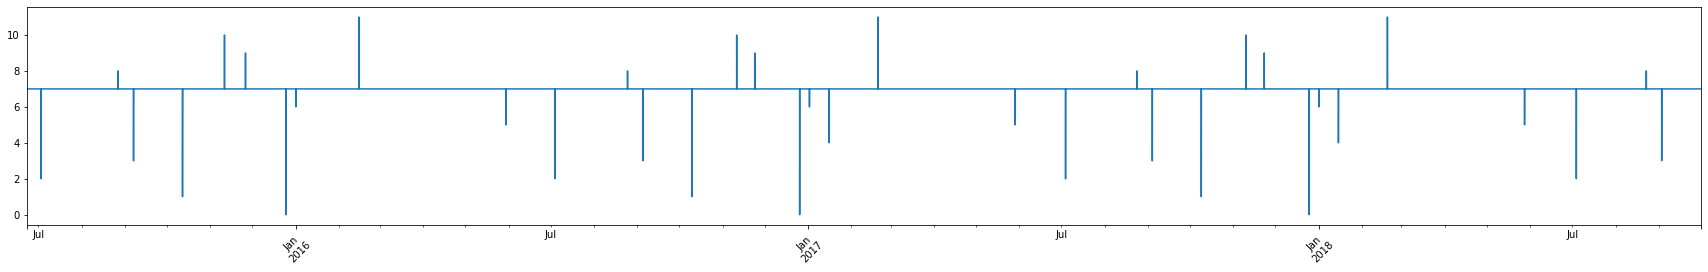

In [64]:
plot_data(data["holiday"])

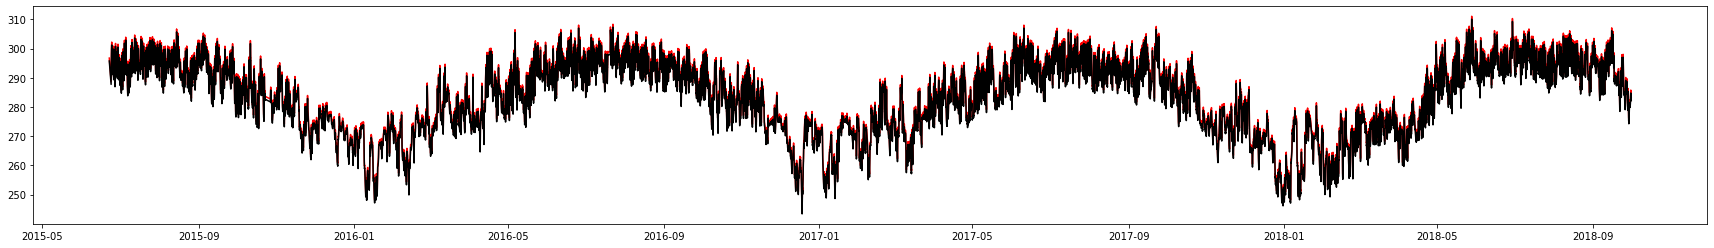

In [65]:
plt.plot(data_.index, data_["temp"].values + 1, color="r")
plt.plot(data.index, data["temp"].values, color="black")
plt.show()

По графикам представленным выше видно, что загруженне данные от указанной даты и предобработанные совпадают, т.е. в процессе предобработки данные не были искажены.

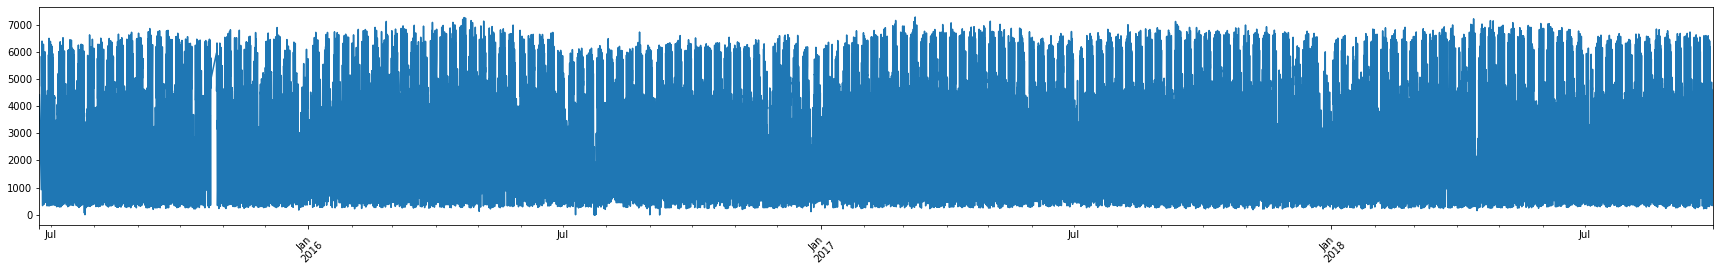

In [66]:
plot_data(data["traffic_volume"])

Из небольших недостатков видно, что в признаке "holiday" не хватает значения 4 в январе 2016 и в в признаке "traffic_volume" до января 2016 есть маленький пропуск значений.

In [67]:
data_orig = data.copy()

Нас интересует недельный прогноз, поэтому возьмем данные за последние 2 месяца 2 недели.

In [68]:
start_dtime = data.index[-1] - (timedelta(days=31*2) + timedelta(days=14))

data = data.loc[start_dtime :]

In [69]:
print(data.index[0], "  -  ", data.index[-1])

2018-07-16 23:00:00   -   2018-09-30 23:00:00


**Разбиваем данные на тренировочные и тестовые (2 недели в тест).**

In [70]:
split_dtime = data.index[-1] - timedelta(days=14)

data_train = data.loc[: split_dtime]
data_test = data.loc[split_dtime :].iloc[1:, :]

In [71]:
base_data_train = data_train.copy()
base_data_test = data_test.copy()

**Генерация дополнительных признаков.**

In [72]:
base_data_train["weekday"] = base_data_train.index.dayofweek
base_data_train["hour"] = base_data_train.index.hour

base_data_test["weekday"] = base_data_test.index.dayofweek
base_data_test["hour"] = base_data_test.index.hour

In [73]:
base_data_train.head(2)

,holiday,temp,traffic_volume,weekday,hour
2018-07-16 23:00:00,7,295.35,1096.0,0,23
2018-07-17 00:00:00,7,294.58,595.0,1,0


In [74]:
base_data_test.head(2)

,holiday,temp,traffic_volume,weekday,hour
2018-09-17 00:00:00,7,296.58,550.0,0,0
2018-09-17 01:00:00,7,296.19,280.0,0,1


In [75]:
train_data_mean = base_data_train.groupby(["weekday", "hour"])["traffic_volume"].mean().to_dict()        # Среднее по день недели, час на тренировочных данных

forecast = base_data_test[["weekday", "hour"]].apply(lambda vals: train_data_mean[tuple(vals)], axis=1)  # Прогноз

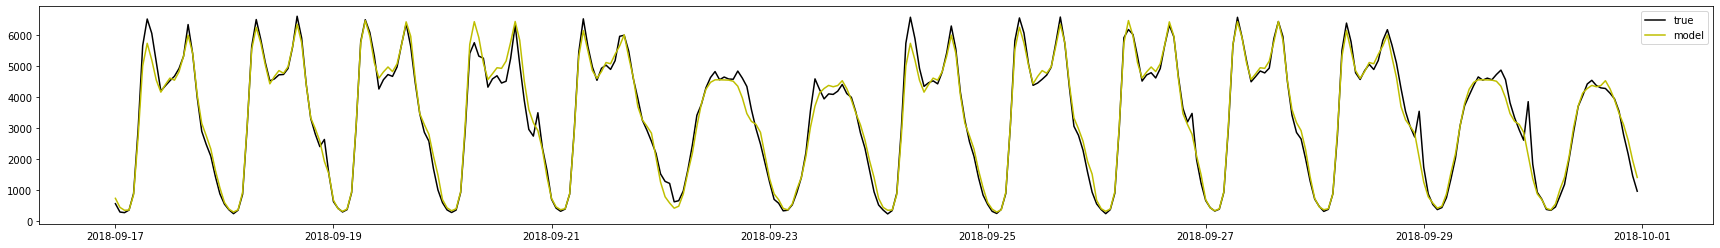

In [76]:
plt.plot(base_data_test["traffic_volume"], color="black", label="true")
plt.plot(forecast, color="y", label="model")
plt.legend()
plt.show()

In [77]:
mean_absolute_percentage_error(base_data_test["traffic_volume"], forecast) * 100

8.49888423599788

In [78]:
mean_absolute_error(base_data_test["traffic_volume"], forecast)

192.1895667989418

**Модель Holt-Winters.**

In [79]:
model = ExponentialSmoothing(data_train["traffic_volume"], trend=None, seasonal='add', seasonal_periods=24*7, damped=False, freq="H")

model_fit = model.fit(optimized=True, use_boxcox=False, remove_bias=False)

forecast = model_fit.predict(start=data_test.index[0], end=data_test.index[-1])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [80]:
mean_absolute_percentage_error(data_test["traffic_volume"], forecast) * 100

29.989020125579252

In [81]:
mean_absolute_error(data_test["traffic_volume"], forecast)

464.70086171051105

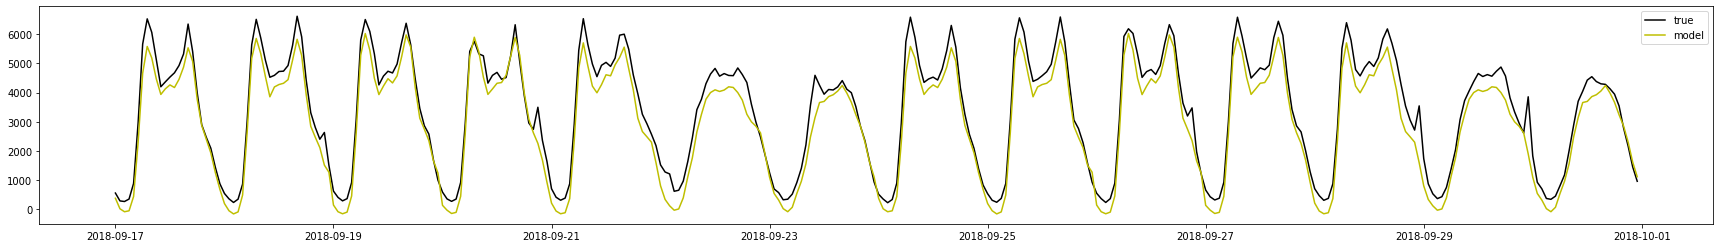

In [82]:
plt.plot(data_test["traffic_volume"], color="black", label="true")
plt.plot(forecast, color="y", label="model")
plt.legend()
plt.show()

**Модель ARIMA (ARMA).**

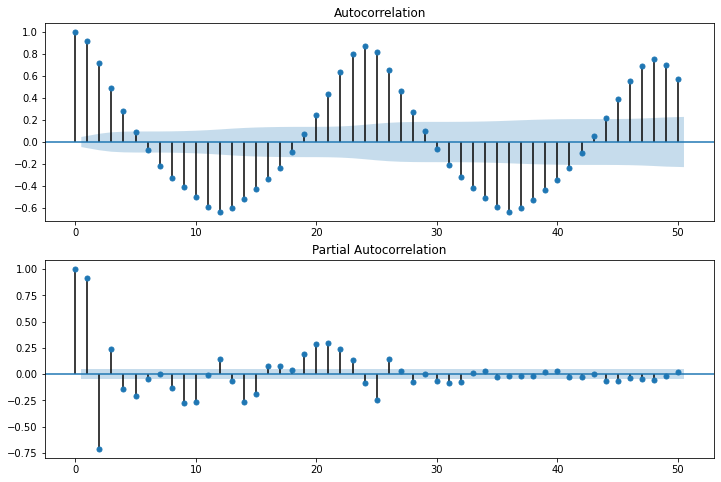

In [83]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data["traffic_volume"], lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data["traffic_volume"], lags=50, ax=ax2)

In [84]:
p, d, q = 3, 0, 4

model = ARIMA(data_train["traffic_volume"], order=(p, d, q), freq="H")

model_fit = model.fit()

forecast = model_fit.predict(start=data_test.index[0], end=data_test.index[-1], dynamic=True)

In [85]:
mean_absolute_percentage_error(data_test["traffic_volume"], forecast) * 100

58.00225278322051

In [86]:
mean_absolute_error(data_test["traffic_volume"], forecast)

893.596872213131

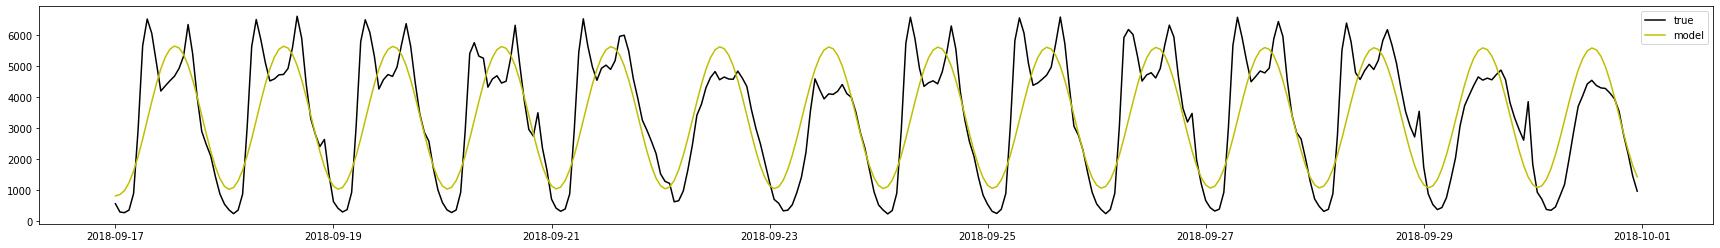

In [87]:
plt.plot(data_test["traffic_volume"], color="black", label="true")
plt.plot(forecast, color="y", label="model")
plt.legend()
plt.show()

Видно, что данная модель не учитывает сезонность и делает средний прогноз по тренировочным данным.

**Модель SARIMA.**

In [88]:
p, d, q = 3, 0, 4
P, D, Q = 0, 1, 0
s = 24*7

model = sm.tsa.statespace.SARIMAX(data_train["traffic_volume"],
                                  order=(p, d, q),
                                  seasonal_order=(P, D, Q, s), freq="H").fit(disp=-1)

forecast = model.predict(start=data_test.index[0], end=data_test.index[-1], dynamic=True)

Ошибка за 1-й месяц на тренировочных данных:

In [89]:
mean_absolute_percentage_error(data_train['traffic_volume'].iloc[s+d : 24*31 + s+d], model.fittedvalues[s+d : 24*31 + s+d]) * 100

6.580515068176387

Ошибка на тестовых данных:

In [90]:
mean_absolute_percentage_error(data_test['traffic_volume'], forecast) * 100

9.259832231653029

In [91]:
mean_absolute_error(data_test["traffic_volume"], forecast)

205.98364077426717

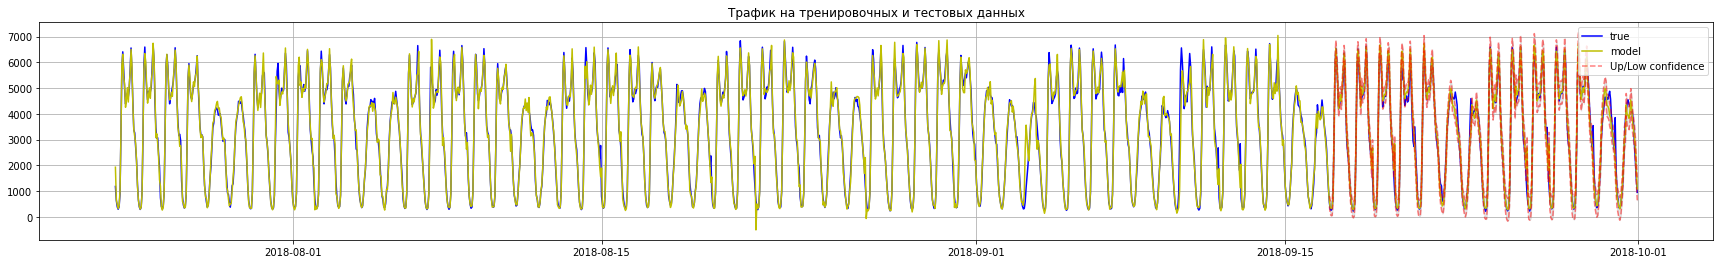

In [92]:
plt.plot(data["traffic_volume"].iloc[s+d : ], color="b", label="true")
plt.plot(pd.DataFrame(np.concatenate((model.fittedvalues, forecast)), columns=["forecast"], index=data.index).iloc[s+d : ], color="y", label="model")

intervals = model.get_forecast(steps=len(data_test)).conf_int(alpha=0.5)
intervals.columns=['lower', 'upper']
plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
plt.plot(intervals['upper'], "r--", alpha=0.5)
plt.fill_between(x=intervals.index, y1=intervals['upper'], y2=intervals['lower'], alpha=0.2, color = "grey")
plt.title("Трафик на тренировочных и тестовых данных")
plt.legend()
plt.grid(True)

plt.show()

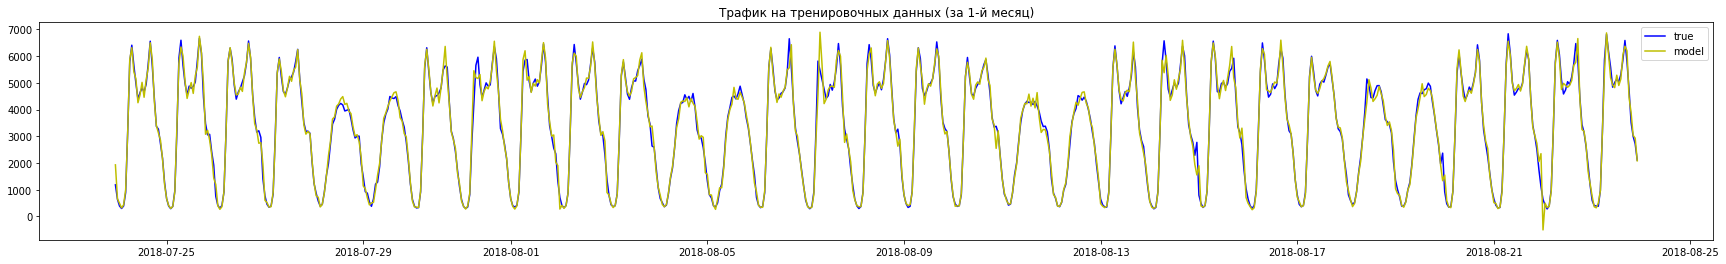

In [94]:
plt.plot(data["traffic_volume"].iloc[s+d : 24*31 + s+d], color="b", label="true")
plt.plot(model.fittedvalues[s+d : 24*31 + s+d], color="y", label="model")
plt.title("Трафик на тренировочных данных (за 1-й месяц)")
plt.legend()

plt.show()

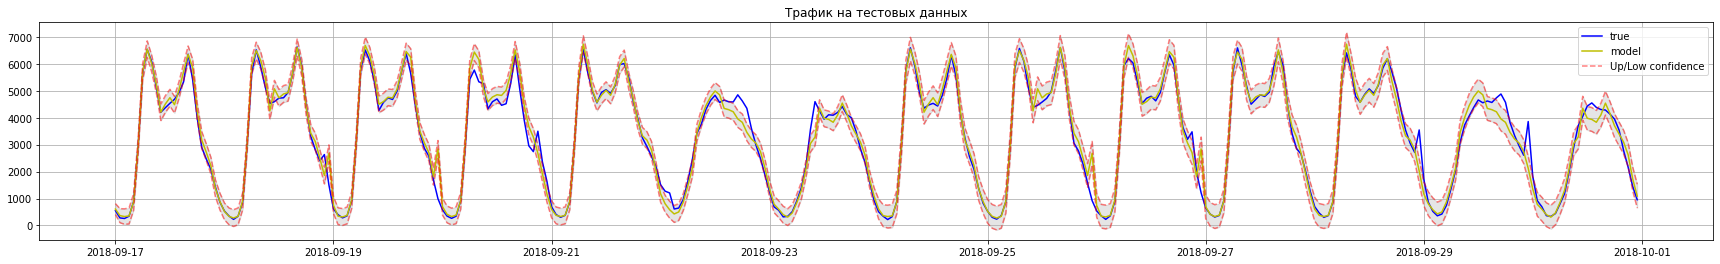

In [208]:
plt.plot(data_test["traffic_volume"], color="b", label="true")
plt.plot(forecast, color="y", label="model")

intervals = model.get_forecast(steps=len(data_test)).conf_int(alpha=0.5)
intervals.columns=['lower', 'upper']
plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
plt.plot(intervals['upper'], "r--", alpha=0.5)
plt.fill_between(x=intervals.index, y1=intervals['upper'], y2=intervals['lower'], alpha=0.2, color = "grey")
plt.title("Трафик на тестовых данных")
plt.legend()
plt.grid(True)

plt.show()

Ошибка данной модели наименьшая из всех других моделей и составляет 9.2 %, немного больше baseline-модели - 8.5 %, ошибка же на тестовых данных за 1-й месяц составляет 6.5 %. Большая ошибка модели не значит, что она хуже baseline-модели, а значит, что факт и прогноз не всегда совпадает. По графику видно, что прогноз по модели и факт отличается на некоторых отрезках больше допустимого значения.

**Прогноз по температуре.**

In [144]:
data = data_orig["2016-07" :]

split_dtime = data.index[-1] - timedelta(days=14)

data_train = data.loc[: split_dtime]
data_test = data.loc[split_dtime :].iloc[1:, :]

In [145]:
data_train_d = data_train.resample('2D').mean()
data_test_d = data_test.resample('2D').mean()

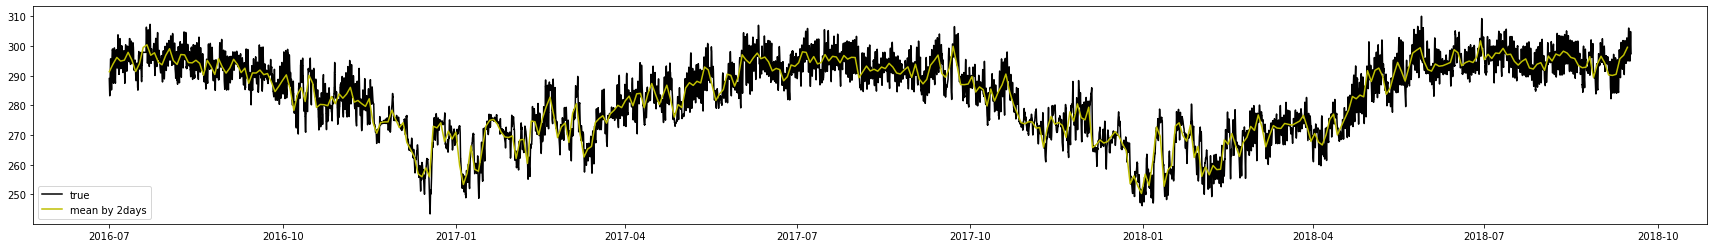

In [146]:
plt.plot(data_train["temp"], color="black", label="true")
plt.plot(data_train_d["temp"], color="y", label="mean by 2days")
plt.legend()
plt.show()

In [147]:
p, d, q = 3, 0, 4
P, D, Q = 0, 1, 0
s = 182

model = sm.tsa.statespace.SARIMAX(data_train_d["temp"],
                                  order=(p, d, q),
                                  seasonal_order=(P, D, Q, s), freq="2D").fit(disp=-1)

forecast = model.predict(start=data_test_d.index[0], end=data_test_d.index[-1], dynamic=True)

In [148]:
fittedvalues = model.fittedvalues[s+d :].resample('H')

fittedvalues = fittedvalues.interpolate(method="time")

y_train = data_train["temp"][s*48+d :]

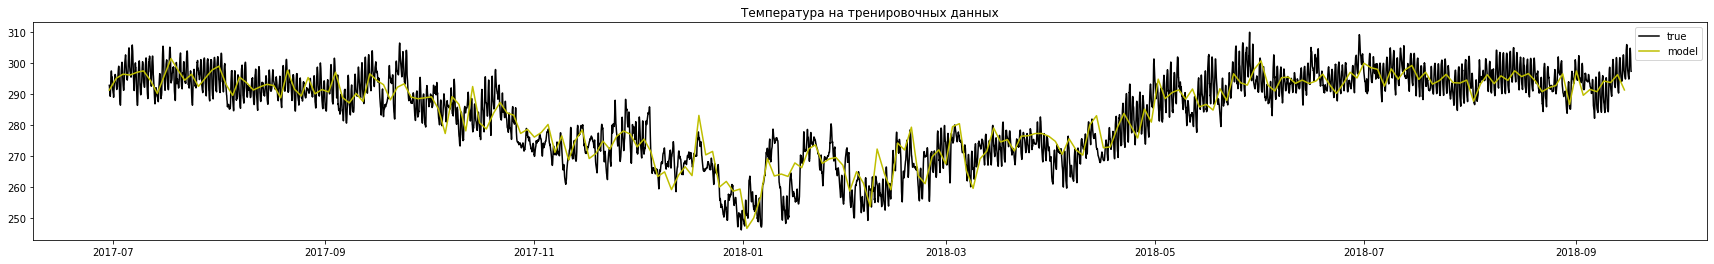

In [149]:
plt.plot(y_train, color="black", label="true")
plt.plot(fittedvalues, color="y", label="model")
plt.title("Температура на тренировочных данных")
plt.legend()
plt.show()

In [150]:
mean_absolute_percentage_error(y_train[: -(len(y_train) - len(fittedvalues))], fittedvalues) * 100

1.4974899267213955

In [151]:
forecast_ = forecast.resample('H')

forecast_ = forecast_.interpolate(method="time")

forecast_ = pd.concat([forecast_, pd.Series(forecast_[-1], index=data_test.index[-(len(data_test) - len(forecast_)) : ])])

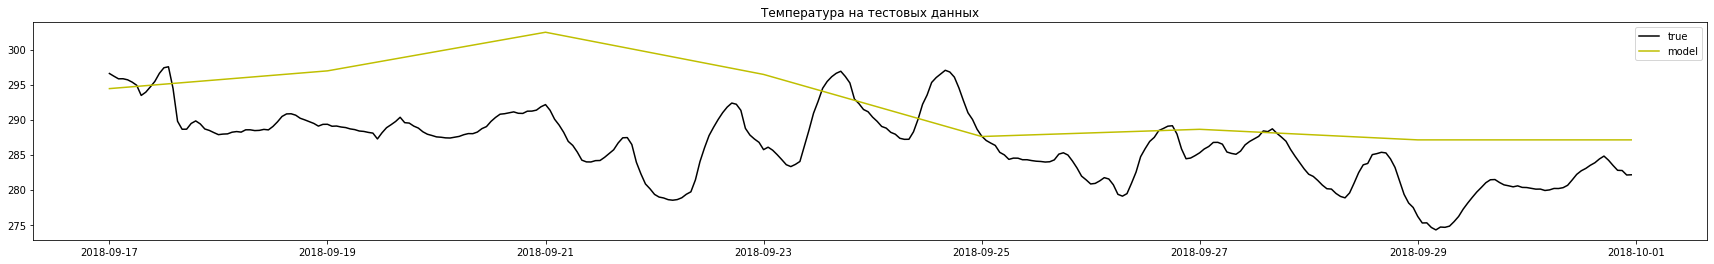

In [152]:
plt.plot(data_test["temp"], color="black", label="true")
plt.plot(forecast_, color="y", label="model")
plt.title("Температура на тестовых данных")
plt.legend()
plt.show()

In [153]:
mean_absolute_percentage_error(data_test["temp"], forecast_) * 100

2.4916692751004748

In [154]:
mean_absolute_error(data_test["temp"], forecast_)

7.102547761864103